<b> Transfer Learning for Flower Classification <b>

<b>Description:<b>

Use a pre-trained model (e.g., MobileNetV2 or VGG16) with weights from ImageNet.

Freeze the base layers and train a new classification head on the tf_flowers dataset.

Then, experiment with fine-tuning (unfreezing some of the later base layers) to improve accuracy.

<b>Concepts:<b>

Transfer Learning

Fine-Tuning

Feature Extraction

tf.keras.applications

<b> Dataset: <b>

tensorflow_datasets.load('tf_flowers')


<b>Data Loading and Preprocessing<b>

-This section loads the <b> tf_flowers <b>  dataset using TensorFlow Datasets (TFDS) and prepares it for model training.

-We split the dataset into <b> training and validation sets <b> and apply preprocessing such as <b> resizing and <b> normalization.

-Images are resized to 224x224, normalized to the [0,1] range, and efficiently batched using TensorFlow pipelines.


In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Enables eager mode
import io
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load and split the dataset
(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Preprocessing: Resizing & Normalization
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing with augmentation (for training)
def preprocess_with_aug(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    image = data_augmentation(image)
    return image, label

# Preprocessing without augmentation (for validation)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# Apply preprocessing to datasets
ds_train = ds_train.map(preprocess_with_aug, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<b> Custom Optimizer Implementation <b>

In this step, a custom optimizer MySGDOptimizer is defined by subclassing tf.keras.optimizers.Optimizer.
It performs parameter updates similar to standard SGD using the update_step() method.
This allows full control over how gradients are applied, which is useful for experimenting with new training strategies.

In [2]:
@tf.keras.utils.register_keras_serializable()
class MySGDOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, name="MySGDOptimizer", **kwargs):
        #Learning rate is passed to the base class
        super().__init__(name=name, learning_rate=learning_rate, **kwargs)
        self._learning_rate = learning_rate

    def update_step(self, grad, var, learning_rate=None, **kwargs):
        if grad is None:
            return
        lr = learning_rate if learning_rate is not None else self._learning_rate
        var.assign_sub(lr * grad)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "learning_rate": self._learning_rate}

<b>Loading and Freezing the Pretrained Base Model<b>

Loads a pretrained MobileNetV2 model with weights trained on ImageNet (a massive image classification dataset).

Sets include_top=False to remove the original classification head, so you can add your own for the flower dataset.

Freezes the base model (base_model.trainable = False) to prevent updating the pretrained weights during training, allowing the model to reuse learned features like edges, textures, and shapes.

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Loads the base model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model


<b>Building the Custom Classification Head using Dense Layers<b>

This step adds a new classifier (head) on top of the pretrained MobileNetV2 base to adapt it for the tf_flowers classification task.
After freezing the base model, we add several fully connected (Dense) layers to interpret features and make predictions.

GlobalAveragePooling2D reduces the output feature maps of the base model to a 1D vector.

Dense layers are added to increase model capacity.

BatchNormalization is used to stabilize learning.

Dropout helps reduce overfitting.

The final Dense layer with softmax activation outputs class probabilities for the flower types.

Using different activation functions in different layers can combine their strengths and help the model learn richer and more flexible patterns.

<b>Activation Functions Used:<b>

1.Swish: Swish learns more complex patterns early on, ReLU simplifies and finalizes decisions.

2.ReLU: Faster training, avoids overfitting, simplifies the final step

In [4]:
num_classes = ds_info.features['label'].num_classes
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),  
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,628,933 (10.03 MB)

 Trainable params: 370,181 (1.41 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

<b>Model Compilation and Training using Custom Focal Loss and Optimizer<b>

Defines a custom focal loss function – to focus training more on hard-to-classify samples.

Compiles the model with:

A custom SGD optimizer (MySGDOptimizer) with a specified learning rate.

The focal loss as the objective function.

Accuracy as the evaluation metric.

<b>Focal Loss adds a modulating term to cross-entropy to focus learning on hard or misclassified examples.<b>

Helps in class imbalance situations by reducing the weight of easy examples.

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Customized focal loss function for sparse labels
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss
optimizer_head = MySGDOptimizer(learning_rate=0.01)

model.compile(
    optimizer=optimizer_head,
              loss=focal_loss(gamma=2.0,alpha=0.25),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_val, epochs=5)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 769s 8s/step - accuracy: 0.2970 - loss: 0.3568 - val_accuracy: 0.5817 - val_loss: 0.1732
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 689s 7s/step - accuracy: 0.4721 - loss: 0.2225 - val_accuracy: 0.7248 - val_loss: 0.1161
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 567s 6s/step - accuracy: 0.5629 - loss: 0.1678 - val_accuracy: 0.7643 - val_loss: 0.0879
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 726s 8s/step - accuracy: 0.6207 - loss: 0.1454 - val_accuracy: 0.7861 - val_loss: 0.0749
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.6550 - loss: 0.1230 - val_accuracy: 0.8065 - val_loss: 0.0678


In [59]:
final_train_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")

Final Training Accuracy: 0.8639


<b> Training History Visualization <b>

It extracts the training and validation accuracy and loss values from the history object that comes from model.fit.

It plots two graphs: one showing training and validation accuracy over the epochs, and the other showing training and validation loss.

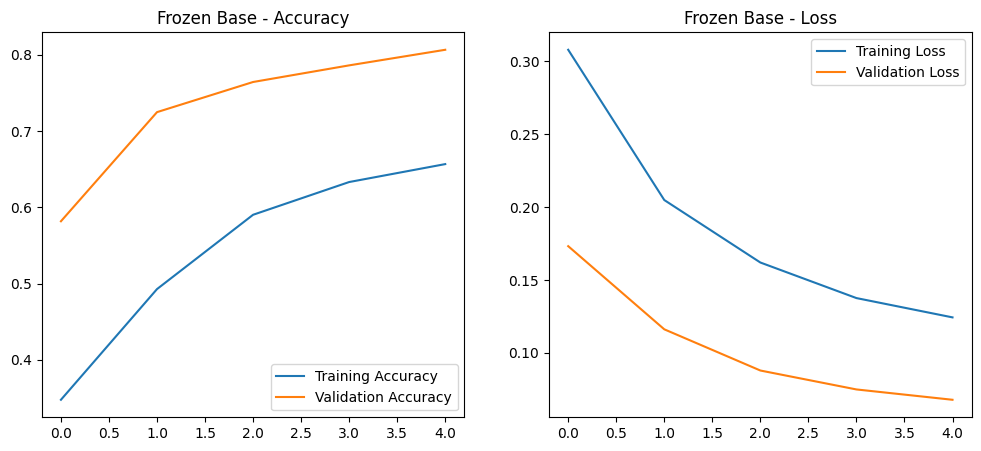

In [6]:
def plot_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

plot_history(history, title="Frozen Base")

<b>Fine-Tuning the Pretrained Model<b>

This step unfreezes the last few layers of the base model to allow them to learn from the new data.

It compiles the model again using a lower learning rate so that the updates to the pretrained weights are small and controlled.

It continues training the model so that the previously frozen layers can adapt and improve performance on the new dataset.

In [7]:
# Unfreezing few deeper layers
base_model.trainable = True

# Freeze all layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

optimizer_head_finetune = MySGDOptimizer(learning_rate=1e-5)
model.compile(
    optimizer=optimizer_head_finetune,
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)
# Fine-tuning
fine_tune_history = model.fit(ds_train, validation_data=ds_val, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 433s 5s/step - accuracy: 0.5091 - loss: 0.1951 - val_accuracy: 0.8038 - val_loss: 0.0682
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 429s 5s/step - accuracy: 0.5311 - loss: 0.1978 - val_accuracy: 0.8120 - val_loss: 0.0690
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 432s 5s/step - accuracy: 0.5179 - loss: 0.1953 - val_accuracy: 0.7984 - val_loss: 0.0703
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 541s 6s/step - accuracy: 0.5043 - loss: 0.1994 - val_accuracy: 0.7970 - val_loss: 0.0714
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.5259 - loss: 0.1888 - val_accuracy: 0.8025 - val_loss: 0.0725


In [30]:

#tf.config.run_functions_eagerly(False)
#model.save('flower_classifier_model.h5')



<b> Model Saving and Graph Optimization Reset <b>

Turns off eager execution, allowing TensorFlow to run in graph mode (faster and more optimized for deployment or saving).

Saves the entire trained model (architecture, weights, and optimizer state) into an HDF5 file named flower_classifier_model.h5.

This saved model can be reloaded later for prediction or further training.

In [8]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)
model.save('flower_classifier_model.h5')
#model.save("flower_classifier_model.keras") 
model = tf.keras.models.load_model("flower_classifier_model.keras",
                                   custom_objects={"loss": focal_loss(gamma=2.0, alpha=0.25)}) 


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 65 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<b>Image Preprocessing for Prediction<b>

Converts uploaded image bytes into a usable RGB image.

Resizes and normalizes the image to match model input.

Returns a batch-ready numpy array for prediction.

In [9]:
from PIL import Image
import numpy as np

def load_image_from_bytes(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    return np.expand_dims(img_array, axis=0)


<b> Flower Prediction and Visualization <b>

Takes image path from user and reads image.

Preprocesses image and runs model prediction.

Displays predicted flower name and confidence.

Shows the image with prediction as title.

Prints all class probabilities.

Plots bar graph of prediction scores, highlighting the predicted class.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import tensorflow_datasets as tfds
ds_info = tfds.builder('tf_flowers').info
class_names = ds_info.features['label'].names

def predict_flower():
    
    print("\nPlease enter the image path:")
    img_path = input().strip()
    
    try:
        with open(img_path, 'rb') as f:
            image_bytes = f.read()
    except FileNotFoundError:
        print("\nFile not found.")
        return

    img_array = load_image_from_bytes(image_bytes)
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction[0])
    confidence = prediction[0][predicted_index]

    CONFIDENCE_THRESHOLD = 0.7
    if confidence < CONFIDENCE_THRESHOLD:
        print("\nLow confidence. The flower is unknown")
        return

    predicted_class = class_names[predicted_index]
    print(f"\nPredicted Flower: {predicted_class} ({confidence * 100:.2f}%)")

    # Image is also shown along with prediction
    img = Image.open(io.BytesIO(image_bytes))
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Probabilities are displayed
    print("\nClass Probabilities:")
    probabilities = prediction[0] * 100  # convert to percentage
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.2f}")
    print(f"\nOverall Accuracy: {confidence * 100:.2f}%")
    #Plotting bar graph of class probabilities
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_names, probabilities, color='skyblue')

    #Predicted class is highlighted in a different color
    bars[predicted_index].set_color('green')

    #Labels are added
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 1,
                 f'{probabilities[i]:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.ylim(0, 100)
    plt.title("Class Probabilities")
    plt.ylabel("Probability (%)")
    plt.xlabel("Flower Classes")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


<b> Evaluation and Performance Visualization <b>

Runs prediction on the entire dataset (like validation set).

Calculates accuracy for each batch and overall dataset.

Plots accuracy over batches and per-class accuracy using bar graphs.

Displays a classification report showing precision, recall, and F1-score.

Helps you understand where the model is strong or weak across classes.


Please enter the image path:


 dandelion.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

Predicted Flower: dandelion (96.47%)


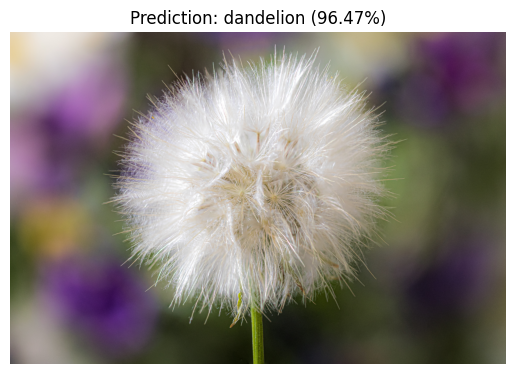


Class Probabilities:
dandelion: 96.47
daisy: 0.10
tulips: 0.70
sunflowers: 0.53
roses: 2.19

Overall Accuracy: 96.47%


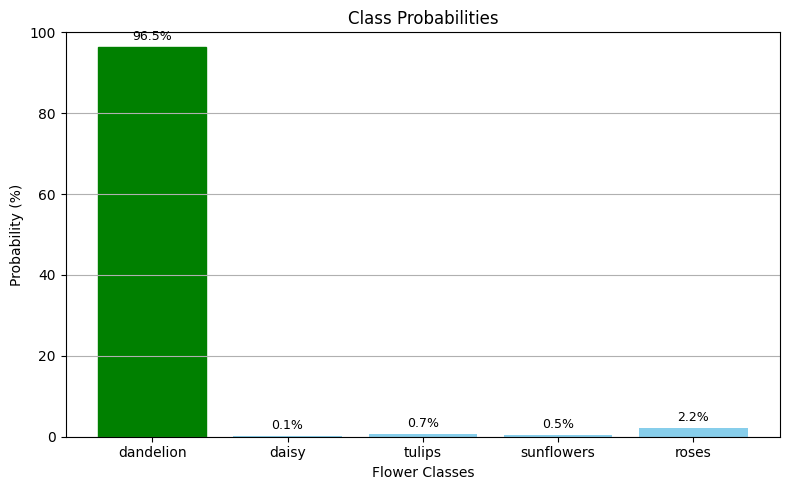

Evaluating model on dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_16804\3569512757.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


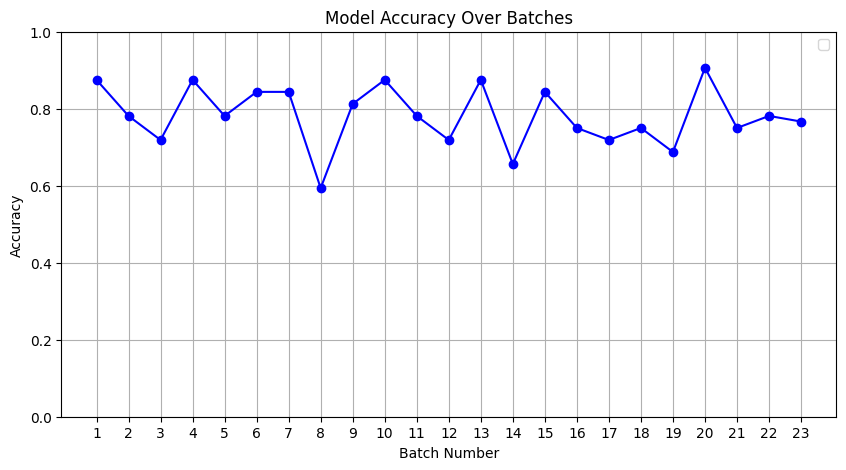

Total samples evaluated: 734
Total batches: 23


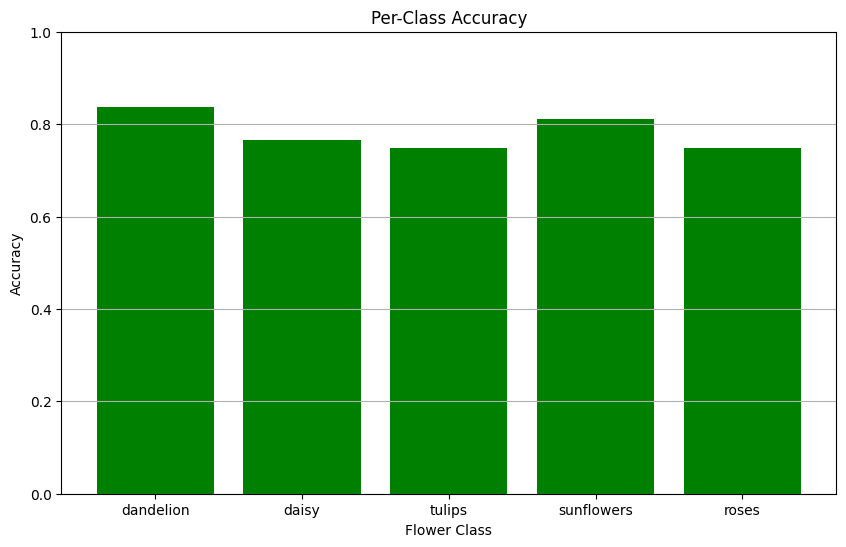

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
#This function evaluates the model on a tf.data dataset and visualizes accuracy.
def evaluate_model_on_dataset(dataset):
   
    y_true = []
    y_pred = []
    accuracies = []

    print("Evaluating model on dataset")

    for images, labels in dataset:
        preds = model.predict(images)
        preds_classes = np.argmax(preds, axis=1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds_classes)
        
        # Current batch accuracies are calculated
        batch_accuracy = accuracy_score(labels.numpy(), preds_classes)
        accuracies.append(batch_accuracy)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    overall_accuracy = accuracy_score(y_true, y_pred)
    
    # Plot accuracy over batches
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b')
    plt.title("Model Accuracy Over Batches")
    plt.xlabel("Batch Number")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.ylim(0, 1)  #Limits from 0 to 1
    plt.xticks(range(1, len(accuracies) + 1))  #x-ticks matches with batch numbers
    plt.grid()
    plt.show()
    print(f"Total samples evaluated: {len(y_true)}")
    print(f"Total batches: {len(accuracies)}")

    #Per class accuracy is computed in this block
    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        idx = (y_true == i)
        if np.sum(idx) == 0:
            accuracy = 0.0
        else:
            accuracy = np.mean(y_pred[idx] == y_true[idx])
        class_accuracy[class_name] = accuracy

    # Plotting per-class accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracy.keys(), class_accuracy.values(), color='green')
    plt.title("Per-Class Accuracy")
    plt.xlabel("Flower Class")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

if __name__ == "__main__":
    predict_flower() 
    evaluate_model_on_dataset(ds_val)